#### Import libraries.

In [1]:
import pandas as pd
import numpy as np
import regex as re
import ast
import statsmodels.api as sm
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup   
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, LinearRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

#### Read reddit text csv file.

In [14]:
text_df = pd.read_csv("./reddit_text.csv")
text_df.head()

,title,selftext,subreddit,num_comments,score
0,First timer looking for suggestions!,My boyfriend and I are going to NYC tomorrow t...,1,20.0,5.0
1,Chinatown on Christmas Day,Dumb question:. Can I walk in to a restaurant ...,1,5.0,4.0
2,Hidden Gem: Hi Collar's Katsu Sando,notext,1,11.0,36.0
3,anybody want to open a restaurant in Howard be...,notext,1,0.0,0.0
4,Midtown/Hell's Kitchen Suggestions for a small...,"Hey, I've got a group of six hanging around Mi...",1,5.0,1.0


#### Find the number of posts in each subreddit.

In [9]:
num_la = len(text_df[text_df['subreddit'] == 0])

In [10]:
num_nyc = len(text_df[text_df['subreddit'] == 1])

In [11]:
da = pd.DataFrame({'FoodNYC': [num_nyc], 'FoodLosAngeles': [num_la]})
da.rename(index={0:'Number of posts'}, inplace=True) 
da

,FoodNYC,FoodLosAngeles
Number of posts,856,882


#### Plot the number of posts in each subreddit.

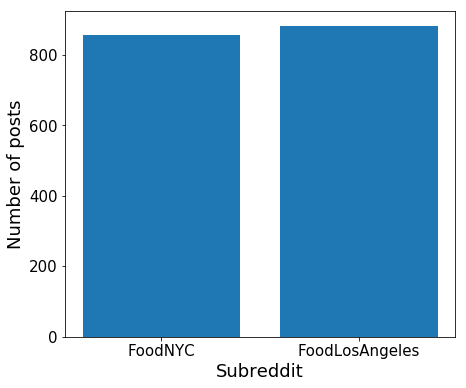

In [3]:
plt.figure(figsize=(7,6))
plt.bar(da.columns, da.loc['Number of posts'], width=0.8)
plt.xlabel('Subreddit', size=18)
plt.ylabel('Number of posts', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig('./number_of_posts.png', )

#### Find the number of notext(null).

In [12]:
len(text_df[text_df['selftext'] == 'notext'])

874

#### There are 874 nulls in 1738 posts. We will still keep this nulls since it might have some meaning

### Let's clean the text (tokenize / lemmatize / stem)

In [16]:
lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()

#### Build a function that tokenize, lemmatize, and stem the posts.

In [17]:
def to_words(raw_text):
    # Function to convert a raw title to a string of words
    # The input is a single string (a raw title), and 
    # the output is a single string (a preprocessed title)
    
    # 1. Remove HTML
    text = BeautifulSoup(raw_text).get_text()
    
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words('english'))
     
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Lemmetize the words.
    tokens_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 7. Stem the words.
    tokens_stem = [p_stemmer.stem(i) for i in tokens_lem] 
    
    # 8. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(tokens_stem))

In [18]:
# Initialize an empty list to hold the clean title.
clean_title = []
clean_selftext = []

In [19]:
# Let's clean the text in training set.
for title in text_df['title']:
    # Convert title to words, then append to clean_train_title.
    clean_title.append(to_words(title)) 

# Let's do the same for our testing set.
for selftext in text_df['selftext']:
    # Convert review to words, then append to clean_train_reviews.
    clean_selftext.append(to_words(selftext))

/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://gothamist.com/2017/10/30/latelier_de_joel_robuchon.php#photo-1" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://www.ramenyokochous.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [20]:
text_df['title'] = clean_title
text_df['selftext'] = clean_selftext

## Modeling

### Train/test split

In [24]:
features = ['selftext', 'title']
X = text_df[features]
y = text_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify=y)

In [25]:
# Add some stopwords.
stopword = stopwords.words("english")
stopword = stopword + ['nyc', 'ny', 'new', 'york', 'ca', 'la', 'los', 'angeles']

In [26]:
# Instantiate the "CountVectorizer" object.

vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = stopword, 
                             ngram_range = (1,2),
                             max_features = 5000) 

In [27]:
# Fit and transform CountVectorizer of each train and test set of 'title' and 'selftext.'

clean_title_train_features = vectorizer.fit_transform(X_train['title'])
title_X_train = pd.DataFrame(clean_title_train_features.toarray(), 
                             columns=vectorizer.get_feature_names())

clean_title_test_features = vectorizer.transform(X_test['title'])
title_X_test = pd.DataFrame(clean_title_test_features.toarray(), 
                             columns=vectorizer.get_feature_names())

clean_selftext_train_features = vectorizer.fit_transform(X_train['selftext'])
selftext_X_train = combined_X = pd.DataFrame(clean_selftext_train_features.toarray(), 
                                       columns=vectorizer.get_feature_names())

clean_selftext_test_features = vectorizer.transform(X_test['selftext'])
selftext_X_test = combined_X = pd.DataFrame(clean_selftext_test_features.toarray(), 
                                       columns=vectorizer.get_feature_names())

In [28]:
# Combine 'title' and 'selftext' in train set.
X_train_comb = pd.merge(title_X_train, 
                        selftext_X_train, 
                        left_index=True, right_index=True)

In [29]:
# Combine 'title' and 'selftext' in test set.
X_test_comb = pd.merge(title_X_test, 
                       selftext_X_test, 
                       left_index=True, right_index=True)

### Logistic Regression

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [221]:
logreg = LogisticRegression()

In [222]:
cross_val_score(logreg, X_train_comb, y_train).mean()

0.7267828451365714

In [223]:
logreg.fit(X_train_comb, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [224]:
logreg.score(X_test_comb, y_test)

0.735632183908046

In [227]:
my_params = {
    'penalty': ['l1', 'l2'],
    'tol': [0.000001, 0.00001, 0.0001, 0.001, 0.01],
    'C': [100, 10, 1, 0.1, 0.01],
}
gs = GridSearchCV(estimator=logreg, param_grid=my_params, cv=5)
gs.fit(X_train_comb, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'tol': [1e-06, 1e-05, 0.0001, 0.001, 0.01], 'C': [100, 10, 1, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [228]:
gs.best_score_

0.7221795855717574

In [229]:
gs.best_params_

{'C': 1, 'penalty': 'l2', 'tol': 1e-06}

In [231]:
logreg.fit(X_train_comb, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=1e-06, verbose=0, warm_start=False)

In [266]:
logreg.score(X_train_comb, y_train)

0.9930928626247122

In [232]:
logreg.score(X_test_comb, y_test)

0.735632183908046

In [233]:
logreg.coef_

array([[ 8.87010068e-02, -7.94176694e-02,  9.34295321e-02, ...,
         8.01272118e-02, -7.48772707e-02,  9.02715688e-08]])

In [234]:
X_train_comb.columns

Index(['abc', 'absolut_x', 'across_x', 'actual_x', 'add_x', 'advanc_x',
       'advic_x', 'afford_x', 'age_x', 'aggreg',
       ...
       'yoyfq', 'yoyfq xzucm', 'yummi_y', 'zac', 'zac hartog', 'zagat', 'zha',
       'zha jiang', 'zone_y', 'zoo'],
      dtype='object', length=10000)

In [235]:
coeff = pd.DataFrame(logreg.coef_, columns=X_train_comb.columns).T.sort_values(by=0, ascending=False)

In [236]:
coeff['Ratio'] = coeff.apply(lambda row: np.exp(row[0]), axis=1)

In [237]:
coeff.rename(columns={0:'coef'}, inplace=True)

In [238]:
coeff.head(50)

,coef,Ratio
queen_x,1.284857,3.614150
brooklyn_x,1.193415,3.298326
manhattan_y,1.184726,3.269790
manhattan_x,1.098074,2.998387
star_x,1.037864,2.823181
midtown_x,0.964834,2.624351
infatu_x,0.898597,2.456154
flush_x,0.873474,2.395217
ate_x,0.870936,2.389146
brooklyn_y,0.830597,2.294689


In [239]:
coeff.tail(100)

,coef,Ratio
poke,-0.431906,0.649271
silverlak_x,-0.432159,0.649106
eatali_x,-0.432573,0.648837
chees_y,-0.433541,0.648210
restaur_y,-0.434931,0.647309
go anywher,-0.437663,0.645543
porn,-0.438244,0.645169
mind,-0.438509,0.644997
bay_x,-0.439988,0.644044
univers_x,-0.446460,0.639889


### Randomforest and Extrtrees

In [251]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()

In [252]:
cross_val_score(rf, X_train_comb, y_train, cv=5).mean()

0.6470209659312054

In [253]:
cross_val_score(et, X_train_comb, y_train, cv=5).mean()

0.6731130774405321

In [254]:
my_paramss = {
    "n_estimators": [10, 20, 50, 100], 
    'max_depth': [None, 2, 3, 4],
    'max_features': ['auto', 0.5]    
}
gs = GridSearchCV(rf, param_grid=my_paramss, cv=5)

In [255]:
gs.fit(X_train_comb, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 50, 100], 'max_depth': [None, 2, 3, 4], 'max_features': ['auto', 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [256]:
gs.best_score_

0.6784343821949348

In [257]:
gs.best_params_

{'max_depth': None, 'max_features': 'auto', 'n_estimators': 20}

In [262]:
rf = RandomForestClassifier(n_estimators=20)

In [263]:
rf.fit(X_train_comb, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [264]:
rf.score(X_test_comb, y_test)

0.6620689655172414

In [265]:
rf.score(X_train_comb, y_train)

0.9969301611665388

In [51]:
svc = svm.SVC()

In [53]:
svc.fit(X_train_comb, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [56]:
my_param = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['rbf']#, 'linear', 'poly']
}
gs = GridSearchCV(svc, param_grid=my_param, cv=5)

In [57]:
gs.fit(X_train_comb, y_train)

KeyboardInterrupt: 

In [ ]:
gs.best_score_

In [ ]:
y_pred = svc.predict(X_test_comb)
accuracy_score(y_test, y_pred)

In [ ]:
svc.score(X_train_comb, y_train)

### Multinomial Naive Bayes

In [68]:
nb = MultinomialNB()
model = nb.fit(X_train_comb, y_train)
predictions = model.predict(X_test_comb)
model.score(X_train_comb, y_train)

0.9194167306216423

In [69]:
model.score(X_test_comb, y_test)

0.7080459770114943

### K-nearest neighbors

In [88]:
knn = KNeighborsClassifier()
cross_val_score(KNeighborsClassifier(n_neighbors=10), X_train_comb, y_train).mean()

0.5725338559598848

In [106]:
knn.fit(X_train_comb, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [107]:
knn.score(X_test_comb, y_test)

0.593103448275862

In [90]:
cross_val_score(nb, X_train_comb, y_train).mean()

0.6938132316330314

### DecisionTree

In [92]:
tree = DecisionTreeClassifier()
tree.fit(X_train_comb, y_train)
tree.score(X_train_comb, y_train)

0.9992325402916347

In [93]:
tree.score(X_test_comb, y_test)

0.6114942528735632

### Bagging

In [94]:
bag = BaggingClassifier()
bag.fit(X_train_comb, y_train)
bag.score(X_test_comb, y_test)

0.6459770114942529

In [96]:
bag.score(X_train_comb, y_train)

0.9746738296239448

### AdaBoost

In [183]:
scores_test = []
scores_train = []
n_estimators = []

for n_est in range(50):
    ada = AdaBoostClassifier(n_estimators=n_est+1, random_state=42)
    ada.fit(X_train_comb, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(ada.score(X_test_comb, y_test))
    scores_train.append(ada.score(X_train_comb, y_train))

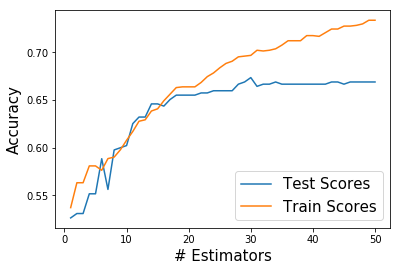

In [184]:
plt.plot(n_estimators, scores_test, label='Test Scores')
plt.plot(n_estimators, scores_train, label='Train Scores')
plt.xlabel('# Estimators', size=15)
plt.ylabel('Accuracy',size=15)
plt.legend(fontsize=15, loc=4)
plt.savefig('./adaboosting.png')

### GradientBoosting

In [128]:
scores_test = []
scores_train = []
n_estimators = []

for n_est in range(50):
    grb = GradientBoostingClassifier(n_estimators=n_est+1, random_state=42)
    grb.fit(X_train_comb, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(grb.score(X_test_comb, y_test))
    scores_train.append(grb.score(X_train_comb, y_train))

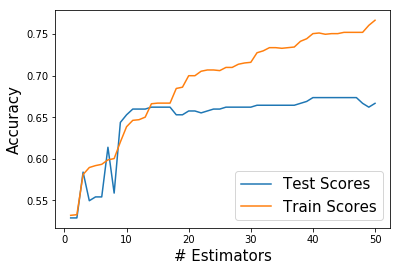

In [181]:
plt.plot(n_estimators, scores_test, label='Test Scores')
plt.plot(n_estimators, scores_train, label='Train Scores')
plt.xlabel('# Estimators', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(fontsize=15, loc=4)
plt.savefig('./gradientboosting.png')

### Plot the accuracy score of each model

In [31]:
accuracy_scoress = {'RandomForest': [0.6229885],
                 'DecisionTree': [0.6114943],
                 'BaggingTree': [0.6459770],
                 'AdaBoost': [0.6735632],
                 'GradientBoosting': [0.6735632],
                 'ExtraTree': [0.7126437],
                 'KNeighbor': [0.5931034],
                 'MultinomialNaiveBeyes': [0.7080460],
                 'LogisticRegression': [0.7356322]}

In [32]:
pd.DataFrame(accuracy_scoress, index=['Accuracy']).T.sort_values('Accuracy', ascending=False)

,Accuracy
LogisticRegression,0.735632
ExtraTree,0.712644
MultinomialNaiveBeyes,0.708046
AdaBoost,0.673563
GradientBoosting,0.673563
BaggingTree,0.645977
RandomForest,0.622988
DecisionTree,0.611494
KNeighbor,0.593103


> It seems that Logistic Regression is more accurate that other models to predict the food trend in NYC or LA.

### Recommendation for launching restaurant businesss in EC and WC.

* Meaningful features from Top 50 features (more relevant to NYC)

> Momofuku, omakaze, chinese, cookie, bagel, bar, rib, 
> restaurant week, food fest, italian, michelin, vegan

* Meaningful features from Bottom 50 features (more relevant to LA)

> Toast, taco, chili, burger, shake shack, potato, donut, tsujita
> Hollywood, cafe


> For NYC (East coast)
- Omakaze, bagel, and italian food are popular in NYC
- Use food fest, restaurant week, michelin star
- Better to have vegan menu

> For West coast
- Burger, taco, chili are popular in LA

> For both
- Japanese restaurant is familiar for EC and WC in general.
